In [53]:
import torch
from nemo.collections.asr.models import EncDecCTCModel
import torchaudio
from itertools import product
import os
import torch.nn as nn
import time, onnxruntime, numpy as np
import matplotlib.pyplot as plt

In [54]:
# --- Load & configure model ---
asr_model = EncDecCTCModel.restore_from("model/stt_hi_conformer_ctc_medium.nemo").eval()
asr_model.preprocessor.featurizer.dither = 0.0
asr_model.preprocessor.featurizer.pad_to = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
asr_model.to(device)

[NeMo I 2025-05-24 17:37:25 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-05-24 17:37:25 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /code/03_manifest/ulca-train-v3.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    
[NeMo W 2025-05-24 17:37:25 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /code/manifest/ulca-eval.json
    sample_rate: 16000
    batch_size: 4
    shuffle: false
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    
[NeMo W 2025-05-24 17:37:25 n

[NeMo I 2025-05-24 17:37:25 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-24 17:37:26 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from d:\IIT BBS\Job Resources\mvaakAI\asr_app\model\stt_hi_conformer_ctc_medium.nemo.


EncDecCTCModelBPE(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=5120, out_features=256, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-17): 18 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, o

In [55]:
# --- Load & preprocess audio ---
wav_path = "test/test1.wav"
waveform, sr = torchaudio.load(wav_path)
if sr != 16000:
    waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

# Mix to mono & reshape
if waveform.size(0) > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

waveform = waveform.squeeze(0)  # [1, N] → [N]
audio_input = waveform.unsqueeze(0).to(device)  # [1, N]
length = torch.tensor([audio_input.shape[1]], dtype=torch.int64).to(audio_input.device)

In [56]:
# --- Updated Wrapper with encoder and decoder separation ---
class ASRWrapper(nn.Module):
    def __init__(self, nemo_model):
        super().__init__()
        self.model = nemo_model

    def forward(self, input_signal, input_signal_length):
        return self.model(input_signal=input_signal, input_signal_length=input_signal_length)
        
wrapper = ASRWrapper(asr_model).to(device)

In [59]:
# --- Parameter grid ---
param_space = {
    "export_params":      [True],
    "opset_version":      [17],
    "do_constant_folding":[True, False],
    "dynamic_axes": [
        {'input_signal': {0: 'batch'}, 'input_signal_length': {0: 'batch'}, 'logits': {0: 'batch'}},
        None
    ]
}
param_grid = list(product(*param_space.values()))
print(f"Total combinations: {len(param_grid)}")
os.makedirs("onnx_models", exist_ok=True)

Total combinations: 4


In [60]:
# --- Export loop ---
exported_models = []
for idx, (export_params, opset, const_fold, dyn_axes) in enumerate(param_grid):
    out_path = f"onnx_models/asr_model_{idx}.onnx"
    try:
        torch.onnx.export(
            wrapper,
            args=(audio_input, length),
            f=out_path,
            input_names=['input_signal', 'input_signal_length'],
            output_names=['logits'],
            export_params=export_params,
            opset_version=opset,
            do_constant_folding=const_fold,
            dynamic_axes=dyn_axes,
            verbose=False
        )
        exported_models.append((out_path, export_params, opset, const_fold, dyn_axes))
        print(f"[OK] {out_path}")
    except Exception as e:
        print(f"[FAIL] {out_path} → {e}")

[FAIL] onnx_models/asr_model_0.onnx → STFT does not currently support complex types  [Caused by the value '826 defined in (%826 : Float(*, *, strides=[159904, 1], requires_grad=0, device=cpu) = onnx::Reshape[allowzero=0](%815, %825), scope: __main__.ASRWrapper::/nemo.collections.asr.models.ctc_bpe_models.EncDecCTCModelBPE::model/nemo.collections.asr.modules.audio_preprocessing.AudioToMelSpectrogramPreprocessor::preprocessor/nemo.collections.asr.parts.preprocessing.features.FilterbankFeatures::featurizer # d:\Anaconda\envs\mvaakai\Lib\site-packages\torch\functional.py:729:0
)' (type 'Tensor') in the TorchScript graph. The containing node has kind 'onnx::Reshape'.] 
    (node defined in d:\Anaconda\envs\mvaakai\Lib\site-packages\torch\functional.py(729): stft
d:\Anaconda\envs\mvaakai\Lib\site-packages\nemo\collections\asr\parts\preprocessing\features.py(384): stft
d:\Anaconda\envs\mvaakai\Lib\site-packages\nemo\collections\asr\parts\preprocessing\features.py(437): forward
d:\Anaconda\env

In [ ]:
# --- Benchmarking ---
def to_numpy(t: torch.Tensor):
    return t.detach().cpu().numpy()

# 1. PyTorch timing
torch_times = []
with torch.no_grad():
    for _ in range(5):
        t0 = time.time()
        _ = wrapper(audio_input, length)
        torch_times.append(time.time() - t0)
torch_avg = sum(torch_times) / len(torch_times)
print(f"PyTorch avg inference: {torch_avg:.4f}s")


In [ ]:
# 2. ONNX timing
onnx_results = []
for path, *_ in exported_models:
    try:
        sess = onnxruntime.InferenceSession(path, providers=["CPUExecutionProvider"])
        inp_names = [i.name for i in sess.get_inputs()]
        input_dict = {
            inp_names[0]: to_numpy(audio_input),
            inp_names[1]: to_numpy(length)
        }
        times = []
        for _ in range(5):
            t0 = time.time()
            _ = sess.run(None, input_dict)
            times.append(time.time() - t0)
        onnx_results.append((path, sum(times)/len(times)))
    except Exception as e:
        print(f"Error on {path}: {e}")


[FAIL] onnx_models/asr_model_0.onnx → Input argument audio_signal has no corresponding input_type match. Existing input_types = dict_keys(['input_signal', 'input_signal_length', 'processed_signal', 'processed_signal_length', 'sample_id'])
[FAIL] onnx_models/asr_model_1.onnx → Input argument audio_signal has no corresponding input_type match. Existing input_types = dict_keys(['input_signal', 'input_signal_length', 'processed_signal', 'processed_signal_length', 'sample_id'])
[FAIL] onnx_models/asr_model_2.onnx → Input argument audio_signal has no corresponding input_type match. Existing input_types = dict_keys(['input_signal', 'input_signal_length', 'processed_signal', 'processed_signal_length', 'sample_id'])
[FAIL] onnx_models/asr_model_3.onnx → Input argument audio_signal has no corresponding input_type match. Existing input_types = dict_keys(['input_signal', 'input_signal_length', 'processed_signal', 'processed_signal_length', 'sample_id'])
[FAIL] onnx_models/asr_model_4.onnx → Input 

In [ ]:

# 3. Results
onnx_results.sort(key=lambda x: x[1])
for p, t in onnx_results:
    print(f"{os.path.basename(p)}: {t:.4f}s")


In [ ]:

# 4. Plot
labels = ["PyTorch"] + [os.path.basename(p) for p,_ in onnx_results]
times  = [torch_avg] + [t for _,t in onnx_results]

plt.figure(figsize=(10,6))
plt.barh(labels, times)
plt.xlabel("Avg Inference Time (sec)")
plt.title("PyTorch vs ONNX Variants")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [ ]:

# 5. Best model
best_model = onnx_results[0][0]
print(f"✅ Best ONNX model: {best_model}")

In [65]:
import torch
import torchaudio
from nemo.collections.asr.models import EncDecCTCModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
asr_model = EncDecCTCModel.restore_from("model/stt_hi_conformer_ctc_medium.nemo")
asr_model.eval().to(device)

[NeMo I 2025-05-24 17:54:57 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-05-24 17:54:57 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /code/03_manifest/ulca-train-v3.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    
[NeMo W 2025-05-24 17:54:57 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /code/manifest/ulca-eval.json
    sample_rate: 16000
    batch_size: 4
    shuffle: false
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    
[NeMo W 2025-05-24 17:54:57 n

[NeMo I 2025-05-24 17:54:57 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-24 17:54:57 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from d:\IIT BBS\Job Resources\mvaakAI\asr_app\model\stt_hi_conformer_ctc_medium.nemo.


EncDecCTCModelBPE(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=5120, out_features=256, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-17): 18 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, o

In [70]:
import torchaudio
import torch
import numpy as np

def load_and_preprocess_audio(filepath, target_sr=16000, expected_input_shape=(1, -1)):
    try:
        # Load audio
        waveform, sr = torchaudio.load(filepath)  # waveform shape: (channels, samples)

        # Check if stereo and convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if needed
        if sr != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
            waveform = resampler(waveform)

        # Normalize audio amplitude to [-1, 1]
        waveform = waveform / waveform.abs().max()

        # Confirm shape
        waveform = waveform.squeeze(0)  # now shape is [samples]
        input_tensor = waveform.unsqueeze(0)  # shape [1, time] for batch dimension

        print(f"Audio loaded: {filepath}")
        print(f"Original SR: {sr}, Resampled SR: {target_sr}")
        print(f"Input Tensor Shape: {input_tensor.shape}")
        print(f"Duration (s): {input_tensor.shape[-1] / target_sr:.2f}")
        return input_tensor, torch.tensor([input_tensor.shape[-1]], dtype=torch.int64)

    except Exception as e:
        print(f"Error loading audio file {filepath}: {e}")
        return None, None

load_and_preprocess_audio("test/test1.wav")


Audio loaded: test/test1.wav
Original SR: 16000, Resampled SR: 16000
Input Tensor Shape: torch.Size([1, 159392])
Duration (s): 9.96


(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0001,  0.0000, -0.0004]]),
 tensor([159392]))

In [68]:
# Load and prepare the waveform
waveform, sample_rate = torchaudio.load("test/test1.wav")  # shape: [channels, time]

# If stereo, convert to mono
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Remove channel dimension to get [time], then unsqueeze batch to get [1, time]
input_signal = waveform.squeeze(0).unsqueeze(0).to(device)

# Get input lengths
input_length = torch.tensor([input_signal.shape[1]], dtype=torch.int64).to(device)

In [69]:
# TorchScript wrapper
class TorchScriptWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_signal, input_signal_length):
        return self.model(input_signal=input_signal, input_signal_length=input_signal_length)

# Create wrapper and trace
wrapper = TorchScriptWrapper(asr_model).eval().to(device)

with torch.no_grad():
    traced_model = torch.jit.trace(wrapper, (sample_input, input_length))
    traced_model.save("nemo_conformer_traced.pt")

print("TorchScript model saved as nemo_conformer_traced.pt")

TypeError: Input shape mismatch occured for input_signal in module EncDecCTCModelBPE : 
Input shape expected = (batch, time) | 
Input shape found : torch.Size([1, 2, 159392])

In [ ]:
import itertools

search_space = {
    'batch_size': [1, 2, 4],
    'input_length_sec': [5, 10, 15],
    'precision': ['float32', 'float16']
}

# Create all combinations
configurations = list(itertools.product(
    search_space['batch_size'],
    search_space['input_length_sec'],
    search_space['precision']
))


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

def generate_dummy_input(batch_size, length_sec, precision, sample_rate=16000):
    length = int(sample_rate * length_sec)
    dtype = torch.float16 if precision == 'float16' else torch.float32
    dummy_audio = torch.randn(batch_size, length, dtype=dtype).cuda()
    dummy_length = torch.full((batch_size,), length, dtype=torch.int32).cuda()
    return dummy_audio, dummy_length

results = []

for batch_size, input_sec, precision in configurations:
    dummy_input, dummy_len = generate_dummy_input(batch_size, input_sec, precision)

    # Convert model to the right precision
    if precision == 'float16':
        model = scripted_model.half()
    else:
        model = scripted_model.float()

    # Warm-up
    for _ in range(5):
        _ = model(dummy_input, dummy_len)

    # Benchmark
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(10):
        _ = model(dummy_input, dummy_len)
    torch.cuda.synchronize()
    end = time.time()

    avg_time = (end - start) / 10
    results.append({
        'batch_size': batch_size,
        'input_sec': input_sec,
        'precision': precision,
        'inference_time': avg_time
    })

    print(f"Batch {batch_size}, Input {input_sec}s, {precision}: {avg_time:.4f}s")


In [1]:
import torch
import torchaudio
from nemo.collections.asr.models import EncDecCTCModel
import itertools
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import onnxruntime as ort
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d:\Anaconda\envs\mvaakai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[NeMo W 2025-05-24 20:52:11 nemo_logging:405] d:\Anaconda\envs\mvaakai\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    


In [2]:
# === Function: Preprocess audio ===
def preprocess_audio(file_path, target_sr=16000):
    waveform, sample_rate = torchaudio.load(file_path)  # (channels, time)
    
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        print("Stereo audio detected. Converting to mono.")
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Resample if needed
    if sample_rate != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
        waveform = resampler(waveform)

    # Normalize
    waveform = waveform / waveform.abs().max()

    # (batch, time)
    input_tensor = waveform.squeeze(0).unsqueeze(0)
    input_length = torch.tensor([input_tensor.shape[1]], dtype=torch.int64)

    return input_tensor.to(device), input_length.to(device)

In [3]:
# === Preprocess a real audio file ===
input_signal, input_length = preprocess_audio("test/test1.wav")
input_signal = input_signal.to(device)
input_length = input_length.to(device)

Stereo audio detected. Converting to mono.


In [5]:
# === Load model ===
asr_model = EncDecCTCModel.restore_from("model/stt_hi_conformer_ctc_medium.nemo")
asr_model.eval().to(device)

[NeMo I 2025-05-24 20:52:52 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-05-24 20:52:52 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /code/03_manifest/ulca-train-v3.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    
[NeMo W 2025-05-24 20:52:52 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /code/manifest/ulca-eval.json
    sample_rate: 16000
    batch_size: 4
    shuffle: false
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    
[NeMo W 2025-05-24 20:52:52 n

[NeMo I 2025-05-24 20:52:52 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-24 20:52:53 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from d:\IIT BBS\Job Resources\mvaakAI\asr_app\model\stt_hi_conformer_ctc_medium.nemo.


EncDecCTCModelBPE(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=5120, out_features=256, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-17): 18 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, o

In [6]:
# === TorchScript wrapper ===
class TorchScriptWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_signal, input_signal_length):
        return self.model(input_signal=input_signal, input_signal_length=input_signal_length)

wrapper = TorchScriptWrapper(asr_model).eval().to(device)

with torch.no_grad():
    traced_model = torch.jit.trace(wrapper, (input_signal, input_length))
    traced_model.save("model/nemo_conformer_traced.pt")

print("✅ TorchScript model saved as nemo_conformer_traced.pt")

✅ TorchScript model saved as nemo_conformer_traced.pt


In [9]:
# === Inference benchmarking ===

scripted_model = torch.jit.load("model/nemo_conformer_traced.pt").to(device)

search_space = {
    'batch_size': [1, 2, 4],
    'input_length_sec': [5, 10, 15],
    'precision': ['float32']  # CPU: no float16!
}
configurations = list(itertools.product(
    search_space['batch_size'],
    search_space['input_length_sec'],
    search_space['precision']
))

def generate_dummy_input(batch_size, length_sec, precision, sample_rate=16000):
    length = int(sample_rate * length_sec)
    dtype = torch.float32  # Only float32 on CPU
    dummy_audio = torch.randn(batch_size, length, dtype=dtype).to(device)
    dummy_length = torch.full((batch_size,), length, dtype=torch.int32).to(device)
    return dummy_audio, dummy_length

results = []

for batch_size, input_sec, precision in configurations:
    dummy_input, dummy_len = generate_dummy_input(batch_size, input_sec, precision)

    model = scripted_model.float()

    # Warm-up
    for _ in range(2):
        _ = model(dummy_input, dummy_len)

    start = time.time()
    for _ in range(5):
        _ = model(dummy_input, dummy_len)
    end = time.time()

    avg_time = (end - start) / 5
    results.append({
        'batch_size': batch_size,
        'input_sec': input_sec,
        'precision': precision,
        'inference_time': avg_time
    })

    print(f"⏱️ Batch {batch_size}, {input_sec}s, {precision}: {avg_time:.4f}s")

⏱️ Batch 1, 5s, float32: 0.1452s
⏱️ Batch 1, 10s, float32: 0.2122s
⏱️ Batch 1, 15s, float32: 0.2817s
⏱️ Batch 2, 5s, float32: 0.1890s
⏱️ Batch 2, 10s, float32: 0.3447s
⏱️ Batch 2, 15s, float32: 0.5540s
⏱️ Batch 4, 5s, float32: 0.3999s
⏱️ Batch 4, 10s, float32: 0.8377s
⏱️ Batch 4, 15s, float32: 1.3527s


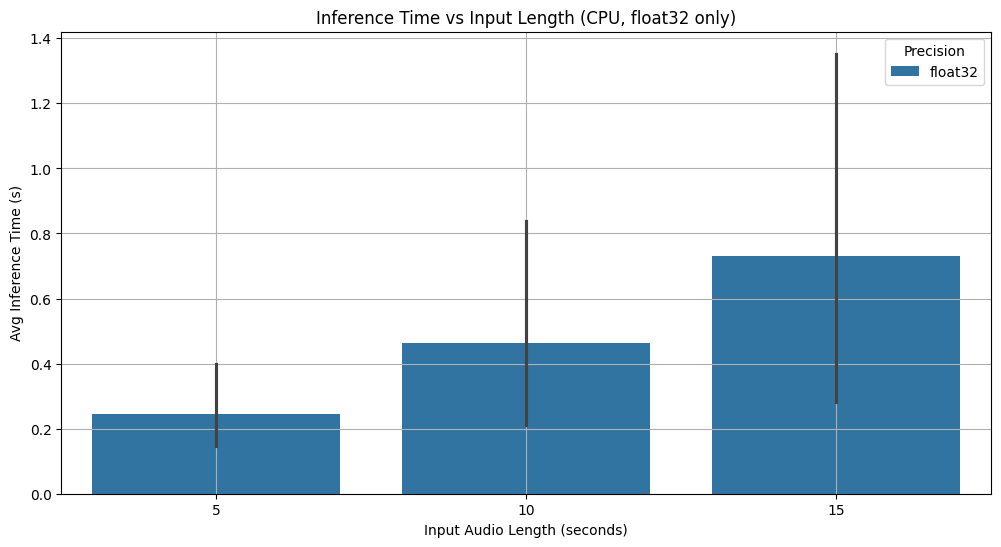

🔥 Best configuration: {'batch_size': 1, 'input_sec': 5, 'precision': 'float32', 'inference_time': 0.145200777053833}


In [10]:
# === Visualization ===
df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='input_sec', y='inference_time', hue='precision')
plt.title("Inference Time vs Input Length (CPU, float32 only)")
plt.xlabel("Input Audio Length (seconds)")
plt.ylabel("Avg Inference Time (s)")
plt.legend(title="Precision")
plt.grid(True)
plt.show()

best_config = min(results, key=lambda x: x['inference_time'])
print("🔥 Best configuration:", best_config)